In [74]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt

In [239]:

# Initialize wandb API
api = wandb.Api()
name = "Trained $\\delta_t$"
# name = "r'$\mathrm{(\Large \delta_t)}$ training"

Models = {"Discrete RAF":{'sweep_ids':["y5j1uqkv", "hbume7i5"]},
           "RAF":{'sweep_ids':["e7nd5dzv"]}, 
           "Continuous domain":{'sweep_ids':["xmxt392x"]},
           name:{'sweep_ids':["irxp75av"]},  
           "Log domain":{'sweep_ids':["sjpedyxt", "r2s3dj5j"]}, 
           "HIPPO init":{'sweep_ids':["wwui18wq", "tqyn6vdh"]},
           "SiLIF":{'sweep_ids':["wfvufo6d"]},}
           ### Ablation
        #    "noInitDtReparam":{'sweep_ids':["ea2m7zno"]},
        #    "noDtHalf":{'sweep_ids':["v1zx6qey"]},
        #    "noDt":{'sweep_ids':["b1moh5g8"]},
        #    "noInitDt":{'sweep_ids':["z9uhmzfn"]},
        #    "noInit":{'sweep_ids':["cmy1qjam"]}}


sweep_params = ['lr', 'pdrop', 'scheduler_patience', 'scheduler_factor', 'dt_max', 'model_name']

In [240]:
# Function to retrieve all runs for a given sweep_id
def get_runs_from_sweep(sweep_id):
    sweep = api.sweep(f"maximes_crew/S3_SHD_runs/{sweep_id}")
    runs = sweep.runs
    data = []
    for run in runs:
        config = run.config
        summary = run.summary
        n_layers = config.get('nb_layers')
        n_hiddens = config.get('nb_hiddens')
        lr = config.get('lr')
        dt_min = config.get('dt_min')
        dt_max = config.get('dt_max')
        pdrop = config.get('pdrop')
        sched_patience = config.get('scheduler_patience')
        sched_factor = config.get('scheduler_factor')
        best_valid_acc = summary.get('best valid acc')

        if best_valid_acc is not None:
            data.append({
                'n_layers': n_layers,
                'n_hiddens': n_hiddens,
                'lr': lr,
                'dt_min': dt_min,
                'dt_max': dt_max,
                'pdrop' : pdrop,
                'scheduler_patience' : sched_patience,
                'scheduler_factor' : sched_factor,
                'best_valid_acc': best_valid_acc
            })
    return pd.DataFrame(data)

# Create a dictionary to hold dataframes for each model
all_model_data = []

# Loop over each model in the Models dictionary
for model_name, model_info in Models.items():
    sweeps = model_info['sweep_ids']
    # Create an empty list to store dataframes for each sweep
    dfs = []
    
    # For each sweep_id in the model's sweep_ids, retrieve the runs and store them in a list of dataframes
    for sweep_id in sweeps:
        df = get_runs_from_sweep(sweep_id)
        if not df.empty:
            df['model_name'] = model_name  # Add the model name to the DataFrame
            all_model_data.append(df)
    
    # # Concatenate all dataframes for the current model
    # if dfs:
    #     Models[model_name]['dataframe'] = pd.concat(dfs, ignore_index=True)
    #     df['model_name'] = model_name  # Add the model name to the DataFrame
    #     all_model_data.append(df)

# Combine all the data into one DataFrame
df_all = pd.concat(all_model_data, ignore_index=True)


In [241]:
sweep_params

['lr',
 'pdrop',
 'scheduler_patience',
 'scheduler_factor',
 'dt_max',
 'model_name']

In [242]:
df_all

,n_layers,n_hiddens,lr,dt_min,dt_max,pdrop,scheduler_patience,scheduler_factor,best_valid_acc,model_name
0,3,512,0.001,0.01,0.7,0.50,10,0.7,0.913076,Discrete RAF
1,3,512,0.001,0.01,0.7,0.50,10,0.7,0.917456,Discrete RAF
2,3,512,0.001,0.01,0.7,0.50,10,0.7,0.908341,Discrete RAF
3,3,512,0.001,0.01,0.7,0.50,10,0.7,0.916785,Discrete RAF
4,3,512,0.001,0.01,0.7,0.50,10,0.7,0.923295,Discrete RAF
...,...,...,...,...,...,...,...,...,...,...
326,3,512,0.005,0.01,0.5,0.25,10,0.7,0.939986,SiLIF
327,3,512,0.005,0.01,0.5,0.25,10,0.7,0.959280,SiLIF
328,3,512,0.005,0.01,0.5,0.25,10,0.7,0.959320,SiLIF
329,3,512,0.005,0.01,0.5,0.25,10,0.7,0.955571,SiLIF


In [243]:
# Group by the sweep params and model_name, then compute the mean of best_valid_acc for each group
df_grouped = df_all.groupby(sweep_params).agg({'best_valid_acc': ['mean', 'std']}).reset_index()

# Calculate the number of runs for each unique configuration
df_all['run_count'] = df_all.groupby(sweep_params).transform('size')

df_grouped['run_count'] = df_grouped.apply(lambda x: df_all[
    (df_all[sweep_params].apply(tuple, axis=1) == tuple(x[sweep_params]))
]['run_count'].iloc[0], axis=1)

# Sort the grouped DataFrame by best_valid_acc in descending order
df_grouped_sorted = df_grouped.sort_values(by=('best_valid_acc', 'mean'), ascending=False).reset_index(drop=True)

In [244]:
df_grouped_sorted[0:10]

lr pdrop scheduler_patience scheduler_factor dt_max  model_name  \
                                                                        
0  0.005  0.25                 10              0.7    0.5       SiLIF   
1  0.005  0.10                 10              0.7    0.5  HIPPO init   
2  0.010  0.10                 10              0.7    0.5  HIPPO init   
3  0.005  0.25                 10              0.7    0.5  HIPPO init   
4  0.010  0.25                 10              0.7    0.5  HIPPO init   
5  0.001  0.50                 10              0.7    0.7  Log domain   
6  0.001  0.25                 10              0.7    0.7  HIPPO init   
7  0.050  0.10                 10              0.7    0.7  HIPPO init   
8  0.001  0.50                 10              0.7    0.7  HIPPO init   
9  0.001  0.25                 10              0.7    0.7  Log domain   

  best_valid_acc           run_count  
            mean       std            
0       0.955982  0.009663         5  
1       0.949092  0.003415         5  
2       0.948027  0.006617         5  
3       0.943545  0.001725         5  
4       0.942464  0.004320         5  
5       0.933341  0.005332         5  
6       0.931929  0.013461         5  
7       0.929995  0.010728         5  
8       0.929285  0.010879         5  
9       0.929253  0.012774         5

In [245]:
# Flatten the multi-level column names for easier access
df_grouped.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_grouped.columns]

# Extract the configuration with the best mean best_valid_acc for each model
best_runs = df_grouped.loc[df_grouped.groupby('model_name_')['best_valid_acc_mean'].idxmax()]

In [246]:
best_runs

,lr_,pdrop_,scheduler_patience_,scheduler_factor_,dt_max_,model_name_,best_valid_acc_mean,best_valid_acc_std,run_count_
31,0.050,0.25,10,0.7,0.7,Continuous domain,0.924755,0.008000,5
15,0.001,0.50,10,0.7,0.7,Discrete RAF,0.922609,0.009171,10
20,0.005,0.10,10,0.7,0.5,HIPPO init,0.949092,0.003415,5
17,0.001,0.50,10,0.7,0.7,Log domain,0.933341,0.005332,5
29,0.050,0.10,10,0.7,0.7,RAF,0.921686,0.006752,5
22,0.005,0.25,10,0.7,0.5,SiLIF,0.955982,0.009663,5
6,0.001,0.10,10,0.7,0.7,Trained $\delta_t$,0.902131,0.006034,5


In [247]:
model_order = list(Models.keys())

# Convert the 'model_name' column to a categorical type with the specified order
best_runs['model_name_'] = pd.Categorical(best_runs['model_name_'], categories=model_order, ordered=True)

# Sort best_runs based on the categorical model_name_ column to enforce the desired order
best_runs_sorted = best_runs.sort_values('model_name_').reset_index(drop=True)


/tmp/ipykernel_2035046/555975499.py:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(


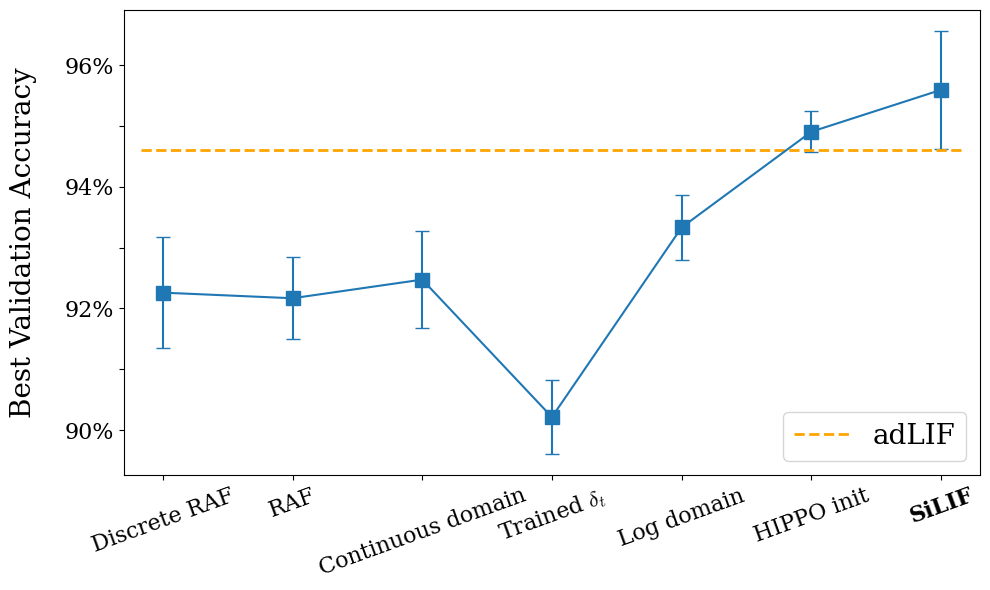

In [248]:
import numpy as np

fontsize=20
labelsize = 16

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False  # Use Matplotlib's built-in math text rendering
plt.rcParams['font.family'] = 'serif'  # Use a serif font to emulate LaTeX style


# Define the x positions for the model names
x_values = np.arange(len(best_runs_sorted['model_name_']))

# Plotting mean and std deviation in the order of the model names
plt.figure(figsize=(10, 6))

# Errorbar plot
plt.errorbar(
    best_runs_sorted['model_name_'], 
    best_runs_sorted['best_valid_acc_mean'], 
    yerr=best_runs_sorted['best_valid_acc_std'], 
    fmt='o', capsize=5, linestyle='-', color='#4F3F84', marker='s',markersize=10,
)


x_min, x_max = plt.xlim()
# Add the orange dashed line for the adLIF model but with space on both ends
plt.plot([0.02, 0.98], [0.9461, 0.9461], '#FF662A', linestyle='--', label='adLIF', transform=plt.gca().get_yaxis_transform(), linewidth=2)

# Rotate x-ticks and set alignment
plt.xticks(rotation=20, ha='center', fontsize=labelsize)

# Set axis labels and title with increased font size
plt.ylabel('Best Validation Accuracy', fontsize=fontsize, labelpad=20)
# plt.title('Mean and Standard Deviation of Best Validation Accuracy for Each Model', fontsize=16)

# Set y-axis labels as percentages and only show even numbers
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y) if (y*100) % 2 == 0 else ''))

# Increase size of tick labels
plt.tick_params(axis='both', which='major', labelsize=labelsize)

labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() == 'SiLIF':
        label.set_fontweight('bold')  # Make ComplexLIF label bold

# Add a legend for the adLIF line
plt.legend(loc='lower right', fontsize=fontsize)

# Adjust layout to fit everything
plt.tight_layout()

plt.savefig("plot_vectorial.pdf", format='pdf', bbox_inches='tight')  # Save as PDF with tight bounding box

# Show the plot
plt.show()